# Building a Euribor Curve - Interpolation Analysis - Complex Case

We build an Ibor single-curve and examine different interpolation choices for a simple curve.

This follows:

https://quant.stackexchange.com/questions/53904/monotonic-cubic-spline-interpolation-quantlib-python?rq=1

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from financepy.utils import *
from financepy.products.rates import *

####################################################################
#  FINANCEPY BETA Version 0.350 - This build: 30 Apr 2024 at 21:20 #
#     This software is distributed FREE AND WITHOUT ANY WARRANTY   #
#  Report bugs as issues at https://github.com/domokane/FinancePy  #
####################################################################



In [3]:
value_dt = Date(12, 5, 2020)

## Building the Single Curve

Build the Ibor Curve

In [4]:
# Need to specify a UK calendar (trade was done in London)
cal = CalendarTypes.UNITED_KINGDOM

depoDCCType = DayCountTypes.ACT_360
depos = []
spot_days = 2
settle_dt = value_dt.add_weekdays(spot_days)
depo = IborDeposit(settle_dt, "6M", -0.496/100.0, depoDCCType, cal_type=cal); depos.append(depo)
fraDCCType = DayCountTypes.ACT_360

fras = []
fra = IborFRA(settle_dt.add_tenor("1M"), "6M", -0.493/100.0, fraDCCType, cal_type=cal); fras.append(fra)
fra = IborFRA(settle_dt.add_tenor("2M"), "6M", -0.491/100.0, fraDCCType, cal_type=cal); fras.append(fra)
fra = IborFRA(settle_dt.add_tenor("3M"), "6M", -0.494/100.0, fraDCCType, cal_type=cal); fras.append(fra)
fra = IborFRA(settle_dt.add_tenor("4M"), "6M", -0.496/100.0, fraDCCType, cal_type=cal); fras.append(fra)
fra = IborFRA(settle_dt.add_tenor("5M"), "6M", -0.499/100.0, fraDCCType, cal_type=cal); fras.append(fra)
fra = IborFRA(settle_dt.add_tenor("6M"), "6M", -0.501/100.0, fraDCCType, cal_type=cal); fras.append(fra)
fra = IborFRA(settle_dt.add_tenor("7M"), "6M", -0.505/100.0, fraDCCType, cal_type=cal); fras.append(fra)
fra = IborFRA(settle_dt.add_tenor("8M"), "6M", -0.508/100.0, fraDCCType, cal_type=cal); fras.append(fra)
fra = IborFRA(settle_dt.add_tenor("9M"), "6M", -0.518/100.0, fraDCCType, cal_type=cal); fras.append(fra)
fra = IborFRA(settle_dt.add_tenor("10M"), "6M", -0.516/100.0, fraDCCType, cal_type=cal); fras.append(fra)
fra = IborFRA(settle_dt.add_tenor("11M"), "6M", -0.518/100.0, fraDCCType, cal_type=cal); fras.append(fra)
fra = IborFRA(settle_dt.add_tenor("12M"), "6M", -0.519/100.0, fraDCCType, cal_type=cal); fras.append(fra)

swaps = []
swap_type = SwapTypes.PAY
fixed_dcc_type = DayCountTypes.THIRTY_E_360_ISDA
fixed_freq_type = FrequencyTypes.SEMI_ANNUAL

swap = IborSwap(settle_dt, "2Y", swap_type, -0.514/100.0, fixed_freq_type, fixed_dcc_type, cal_type=cal); swaps.append(swap)
swap = IborSwap(settle_dt, "3Y", swap_type, -0.506/100.0, fixed_freq_type, fixed_dcc_type, cal_type=cal); swaps.append(swap)
swap = IborSwap(settle_dt, "4Y", swap_type, -0.482/100.0, fixed_freq_type, fixed_dcc_type, cal_type=cal); swaps.append(swap)
swap = IborSwap(settle_dt, "5Y", swap_type, -0.451/100.0, fixed_freq_type, fixed_dcc_type, cal_type=cal); swaps.append(swap)
swap = IborSwap(settle_dt, "6Y", swap_type, -0.415/100.0, fixed_freq_type, fixed_dcc_type, cal_type=cal); swaps.append(swap)
swap = IborSwap(settle_dt, "7Y", swap_type, -0.375/100.0, fixed_freq_type, fixed_dcc_type, cal_type=cal); swaps.append(swap)
swap = IborSwap(settle_dt, "8Y", swap_type, -0.333/100.0, fixed_freq_type, fixed_dcc_type, cal_type=cal); swaps.append(swap)
swap = IborSwap(settle_dt, "9Y", swap_type, -0.288/100.0, fixed_freq_type, fixed_dcc_type, cal_type=cal); swaps.append(swap)
swap = IborSwap(settle_dt, "10Y", swap_type, -0.242/100.0, fixed_freq_type, fixed_dcc_type, cal_type=cal); swaps.append(swap)
swap = IborSwap(settle_dt, "11Y", swap_type, -0.198/100.0, fixed_freq_type, fixed_dcc_type, cal_type=cal); swaps.append(swap)
swap = IborSwap(settle_dt, "12Y", swap_type, -0.156/100.0, fixed_freq_type, fixed_dcc_type, cal_type=cal); swaps.append(swap)
swap = IborSwap(settle_dt, "15Y", swap_type, -0.054/100.0, fixed_freq_type, fixed_dcc_type, cal_type=cal); swaps.append(swap)
swap = IborSwap(settle_dt, "20Y", swap_type, 0.023/100.0, fixed_freq_type, fixed_dcc_type, cal_type=cal); swaps.append(swap)
swap = IborSwap(settle_dt, "25Y", swap_type, 0.023/100.0, fixed_freq_type, fixed_dcc_type, cal_type=cal); swaps.append(swap)
swap = IborSwap(settle_dt, "30Y", swap_type, -0.005/100.0, fixed_freq_type, fixed_dcc_type, cal_type=cal); swaps.append(swap)
swap = IborSwap(settle_dt, "40Y", swap_type, -0.063/100.0, fixed_freq_type, fixed_dcc_type, cal_type=cal); swaps.append(swap)
swap = IborSwap(settle_dt, "50Y", swap_type, -0.113/100.0, fixed_freq_type, fixed_dcc_type, cal_type=cal); swaps.append(swap)

iborDepos = depos.copy()
iborFras = fras.copy()
ibor_swaps = swaps.copy()

In [5]:
iborCurves = {}
for interp_type in InterpTypes:
    iborCurve = IborSingleCurve(value_dt, iborDepos, iborFras, ibor_swaps, interp_type)
    iborCurves[interp_type] = iborCurve

## Curve Shape Analysis

Look at short end

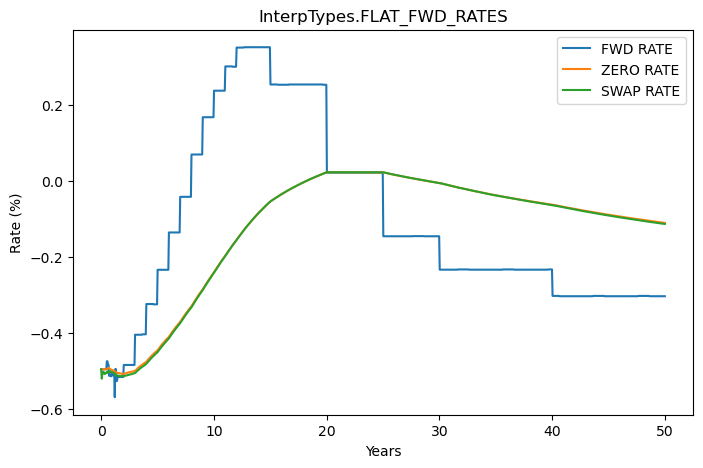

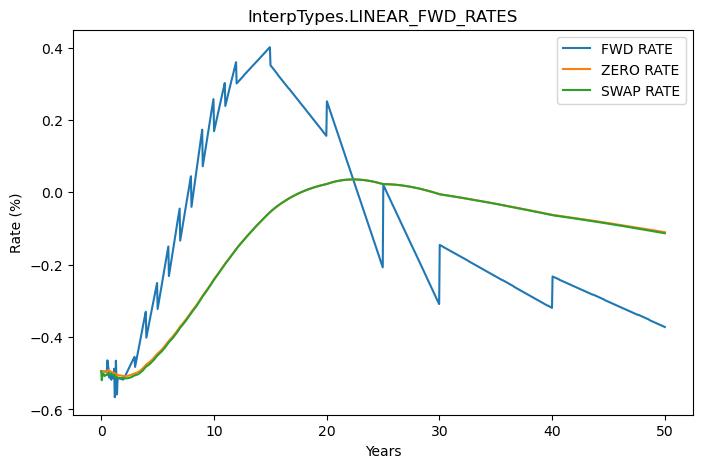

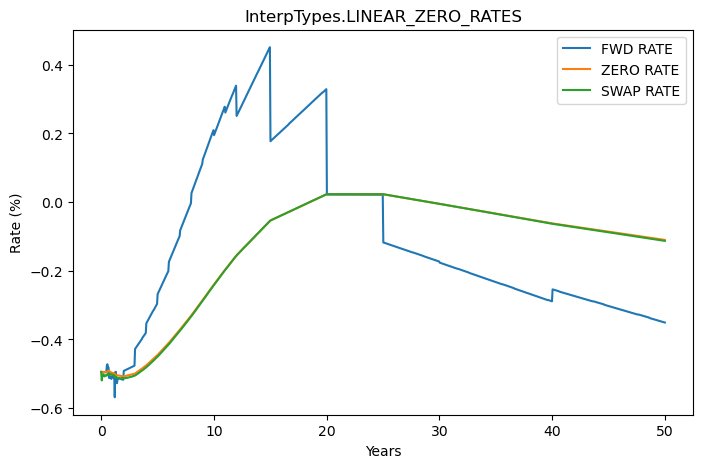

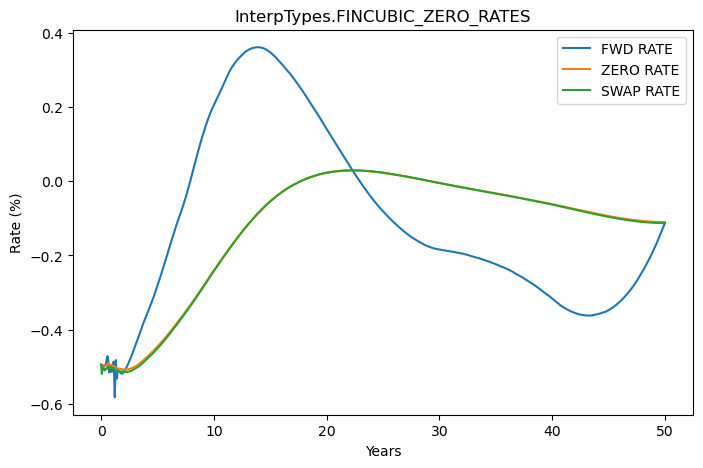

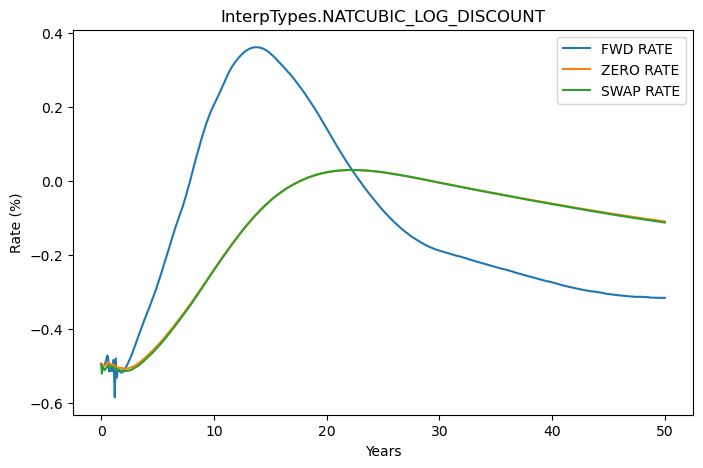

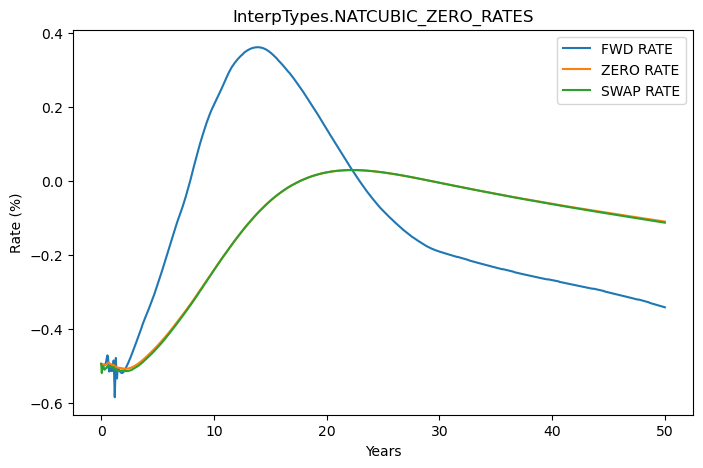

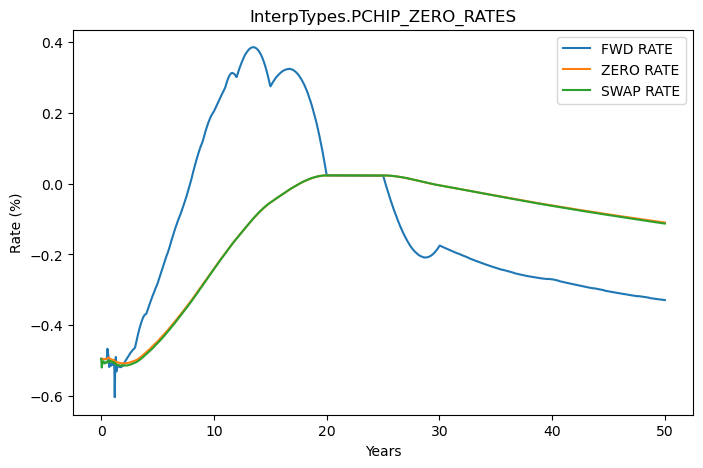

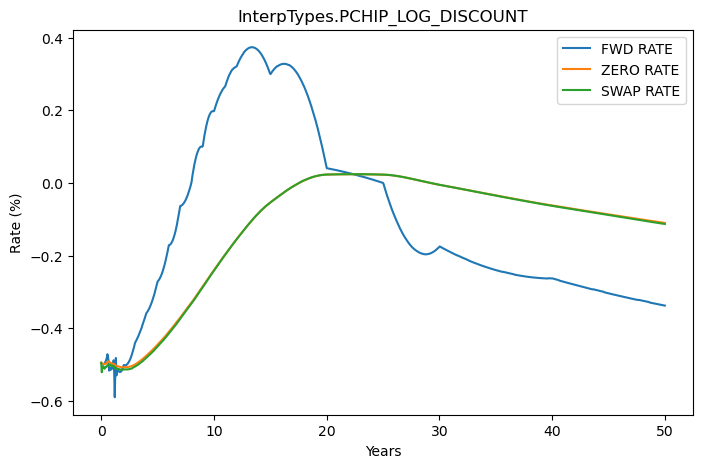

In [6]:
years = np.linspace(0.01, 50, 1000)
plotDates = settle_dt.add_years(years)

for interp_type in InterpTypes:

    plt.figure(figsize=(8,5))
    iborCurve = iborCurves[interp_type]
    iborCurveFwdRate = iborCurve.fwd_rate(plotDates, "1D")
    iborCurveZeroRate = iborCurve.zero_rate(plotDates)
    iborCurveSwapRate = iborCurve.swap_rate(settle_dt, plotDates)
    
    plt.plot(years, iborCurveFwdRate*100.0, label="FWD RATE")
    plt.plot(years, iborCurveZeroRate*100.0, label="ZERO RATE")
    plt.plot(years, iborCurveSwapRate*100.0, label="SWAP RATE")

    plt.title(interp_type)
    plt.xlabel("Years")
    plt.ylabel("Rate (%)")
    plt.legend();

Copyright (c) Dominic O'Kane 2020